In [1]:
import os
import json
import tensorflow as tf
import keras
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from keras.utils.np_utils import to_categorical
from PIL import ImageColor
from Preprocessing.dataset import listSubFiles, groupPaths

# metadata
NUM_CLASSES = 48
X_TARGET_SHAPE = (256, 256, 1)

# hyperparams
EPOCHS = 100
BATCH_SIZE = 8

# Model definition

In [4]:

def ReduceBlock(inputs, features, dropout=0.3):
    # fmt: off
    conv = tf.keras.layers.Conv2D(features, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(inputs)
    conv = tf.keras.layers.Dropout(dropout)(conv)
    conv = tf.keras.layers.Conv2D(features, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(conv)
    maxp = tf.keras.layers.MaxPool2D((2, 2), strides=(2, 2))(conv)
    # fmt: on
    return conv, maxp


def ExpandBlock(inputs, features, concatenate_with):
    # fmt: off
    upsa = tf.keras.layers.Conv2DTranspose(features, (2, 2), strides=(2, 2), padding="same")(inputs)
    upsa = tf.keras.layers.concatenate([upsa, concatenate_with])
    conv = tf.keras.layers.Conv2D(features, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(upsa)
    conv = tf.keras.layers.Dropout(0.3)(conv)
    conv = tf.keras.layers.Conv2D(features, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(conv)
    # fmt: on
    return upsa, conv


def Unet(num_classes, input_shape=(128, 128, 1)):

    inputs = tf.keras.layers.Input(input_shape)
    bn = tf.keras.layers.BatchNormalization()(inputs)

    # Contraction path
    c1, p1 = ReduceBlock(bn, 16, dropout=0.3)
    c2, p2 = ReduceBlock(p1, 32, dropout=0.3)
    c3, _ = ReduceBlock(p2, 64, dropout=0.3)
    # c4, _ = ReduceBlock(p3, 128, dropout=0.3)

    # Expansion path
    # _, c7 = ExpandBlock(c4, 64, concatenate_with=c3)
    _, c8 = ExpandBlock(c3, 32, concatenate_with=c2)
    _, c9 = ExpandBlock(c8, 16, concatenate_with=c1)

    outputs = tf.keras.layers.Conv2D(num_classes + 1, (1, 1), activation="softmax")(c9)
    return inputs, outputs


tf.keras.backend.clear_session()
inputs, outputs = Unet(NUM_CLASSES, X_TARGET_SHAPE)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(
    optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['batch_normalization[0][0]']    
                                )                                                             

# Dataset

In [5]:
# DATASET_PATH = os.path.join("..", "..", "datasets", "generated", "unet")
DATASET_PATH = os.path.join("..", "..", "datasets", "generated", "unet_aug")

paths = listSubFiles(DATASET_PATH, depth=3)
test, train, valid = groupPaths(paths, 2)
train_x, train_y = groupPaths(train, 1)
valid_x, valid_y = groupPaths(valid, 1)

train_x[0], valid_x[0], valid_y[0]

('..\\..\\datasets\\generated\\unet_aug\\train\\x\\0001.png',
 '..\\..\\datasets\\generated\\unet_aug\\valid\\x\\0001.png',
 '..\\..\\datasets\\generated\\unet_aug\\valid\\y\\0001.png')

In [6]:
class Samples(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, num_classes, x_paths, y_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.x_paths = x_paths
        self.y_paths = y_paths
        self.num_classes = num_classes
    
    def __len__(self):
        return len(self.x_paths)
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_x_paths = self.x_paths[i:i + self.batch_size]
        batch_y_paths = self.y_paths[i:i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (1,), dtype=np.uint8)
        for j, x_path in enumerate(batch_x_paths):
            x[j] = 255 - cv2.imread(x_path, cv2.IMREAD_GRAYSCALE)[..., None]
        y = np.zeros((self.batch_size,) + self.img_size + (self.num_classes + 1,), dtype=np.uint8)
        # y = np.zeros((self.batch_size,) + self.img_size + (self.num_classes,), dtype=np.float32)
        for j, y_path in enumerate(batch_y_paths):
            # y[j] = np.load(y_path)
            img = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)
            y[j] = to_categorical(img, self.num_classes + 1)
        return x, y
        

In [7]:
random.Random(1337).shuffle(train_x)
random.Random(1337).shuffle(train_y)

train_gen = Samples(1, (256, 256), 48, train_x, train_y)
valid_gen = Samples(1, (256, 256), 48, valid_x, valid_y)

((1, 256, 256, 1), (1, 256, 256, 49), dtype('uint8'), dtype('uint8'))

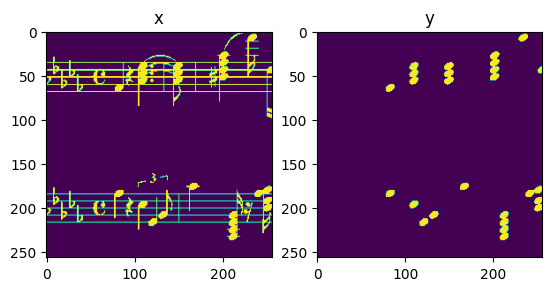

In [8]:
x, y = train_gen.__getitem__(0)

y_vis = np.any(y[0] > 0, axis=2)
fig, axs = plt.subplots(1, 2)
axs[0].imshow(x[0])
axs[1].imshow(np.argmax(y[0], axis=2)==8)
axs[0].set_title("x")
axs[1].set_title("y")
x.shape, y.shape, y.dtype, x.dtype

# Training

In [9]:
OUT_PATH = "../../models"
MODEL_FILENAME = "unet_256x256"

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join(OUT_PATH, MODEL_FILENAME + ".h5"),
        verbose=1,
        mode="min",
        save_best_only=True,
        monitor="val_loss",
    ),
    tf.keras.callbacks.TensorBoard(),
]

history = model.fit(
    train_gen,
    validation_data=valid_gen,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks,
)

# save history as json for further evaluation
history_filename = '{}_history.json'.format(MODEL_FILENAME)
history_filepath = os.path.join(OUT_PATH, history_filename)
with open(history_filepath, 'w') as history_json_file:
    json.dump(history.history, history_json_file)


Epoch 1/100
7679/7680 [============================>.] - ETA: 0s - loss: 0.1259 - accuracy: 0.9660
Epoch 1: val_loss improved from inf to 0.03599, saving model to ../../models\unet_256x256.h5
7680/7680 [==============================] - 280s 35ms/step - loss: 0.1259 - accuracy: 0.9660 - val_loss: 0.0360 - val_accuracy: 0.9875
Epoch 2/100
7679/7680 [============================>.] - ETA: 0s - loss: 0.0341 - accuracy: 0.9886
Epoch 2: val_loss improved from 0.03599 to 0.02270, saving model to ../../models\unet_256x256.h5
7680/7680 [==============================] - 223s 29ms/step - loss: 0.0341 - accuracy: 0.9886 - val_loss: 0.0227 - val_accuracy: 0.9914
Epoch 3/100
7679/7680 [============================>.] - ETA: 0s - loss: 0.0249 - accuracy: 0.9915
Epoch 3: val_loss improved from 0.02270 to 0.01894, saving model to ../../models\unet_256x256.h5
7680/7680 [==============================] - 251s 33ms/step - loss: 0.0249 - accuracy: 0.9915 - val_loss: 0.0189 - val_accuracy: 0.9932
Epoch 4/

# Evaluate Model

In [8]:
DATASET_PATH = os.path.join("..", "..", "datasets", "generated", "unet_aug")
SPLITFILE_PATH = os.path.join("..", "..", "datasets", "generated", "split.csv")

# get file paths
paths = listSubFiles(DATASET_PATH, depth=3)
test, train, valid = groupPaths(paths, 2)
test_x, test_y = groupPaths(test, 1)

# obtain classes
df = pd.read_csv(SPLITFILE_PATH, sep=";", names=["x", "y", "aug", "classname", "outx", "outy"])

# load model
model = keras.models.load_model(os.path.join("..", "..", "models", "unet_256x256.h5"))

with open('../../datasets/generated/classlist.json', 'r') as file:
    classlist = json.load(file)
    class_mapping = {e["class"]: e["id"] for e in classlist}
    class_mapping_inv = {e["id"]: e["class"] for e in classlist}
len(train), len(test), len(valid), len(class_mapping)

(15360, 4800, 3840, 48)

In [5]:
def get_pixel_accuracy(gt_classes, predicted_classes, classIdx):
    
    # Get binary version per class
    pred_binary = predicted_classes == classIdx
    gt_binary = gt_classes == classIdx

    # calculate true positive and true negative
    tp = np.sum(pred_binary * gt_binary)
    tn = np.sum((1 - pred_binary) * (1 - gt_binary))

    # calculate false positive and false negative
    fp = np.sum(pred_binary * (1 - gt_binary))
    fn = np.sum((1 - pred_binary) * gt_binary)

    ac = (tp + tn) / (tp + tn + fp + fn)
    return ac

def get_pixel_fscore(gt_classes, predicted_classes, classIdx):
    
    # Get binary version per class
    pred_binary = predicted_classes == classIdx
    gt_binary = gt_classes == classIdx

    # calculate true positive and true negative
    tp = np.sum(pred_binary * gt_binary)
    tn = np.sum((1 - pred_binary) * (1 - gt_binary))

    # calculate false positive and false negative
    fp = np.sum(pred_binary * (1 - gt_binary))
    fn = np.sum((1 - pred_binary) * gt_binary)

    if tp == 0:
        return 1
    ac = (2 * tp) / (2 * tp + fp + fn)
    return ac



def process_batch_accuracy(batch_size, batch_idx, n_classes):
    batch_x = np.zeros((batch_size, 256, 256, 1), np.uint8)
    batch_y = np.zeros((batch_size, 256, 256), np.uint8)
    batch_paths_x = test_x[batch_idx * batch_size:(batch_idx + 1) * batch_size]
    batch_paths_y = test_y[batch_idx * batch_size:(batch_idx + 1) * batch_size]
    for j in range(batch_size):
        batch_x[j] = cv2.imread(batch_paths_x[j], cv2.IMREAD_GRAYSCALE)[..., None]
        batch_x[j] = np.array((batch_x[j] - np.mean(batch_x[j])) / np.std(batch_x[j])).astype(np.uint8)
        batch_y[j] = cv2.imread(batch_paths_y[j], cv2.IMREAD_GRAYSCALE)

    # predict
    prediction_masks = model.predict(batch_x, verbose=0)

    # extract predicted classes
    predicted_classes = np.zeros_like(batch_y)
    for j in range(batch_size):
        predicted_classes[j] = np.argmax(prediction_masks[j], axis=-1)

    accuracies = np.zeros((batch_size, n_classes), np.float32)
    for j in range(batch_size):
        for c in range(1, n_classes + 1):
            accuracies[j, c-1] = get_pixel_accuracy(batch_y[j], predicted_classes[j], c)
    
    return accuracies

def process_batch_fscore(batch_size, batch_idx, n_classes):
    batch_x = np.zeros((batch_size, 256, 256, 1), np.uint8)
    batch_y = np.zeros((batch_size, 256, 256), np.uint8)
    batch_paths_x = test_x[batch_idx * batch_size:(batch_idx + 1) * batch_size]
    batch_paths_y = test_y[batch_idx * batch_size:(batch_idx + 1) * batch_size]
    for j in range(batch_size):
        batch_x[j] = cv2.imread(batch_paths_x[j], cv2.IMREAD_GRAYSCALE)[..., None]
        batch_x[j] = np.array((batch_x[j] - np.mean(batch_x[j])) / np.std(batch_x[j])).astype(np.uint8)
        batch_y[j] = cv2.imread(batch_paths_y[j], cv2.IMREAD_GRAYSCALE)

    # predict
    prediction_masks = model.predict(batch_x, verbose=0)

    # extract predicted classes
    predicted_classes = np.zeros_like(batch_y)
    for j in range(batch_size):
        predicted_classes[j] = np.argmax(prediction_masks[j], axis=-1)

    accuracies = {}
    for j in range(batch_size):
        for c in range(1, n_classes + 1):
            gt = batch_y[j]
            if c not in gt:
                continue
            accuracy = get_pixel_fscore(gt, predicted_classes[j], c)

            if c in accuracies:
                accuracies[c] += [accuracy]
            else:
                accuracies[c] = [accuracy]
    
    return accuracies

In [9]:
batch_size = 48
n_classes = len(class_mapping)
n_test = len(test_x)
n_batches = int(n_test / batch_size) 

accuracies = {}
total_n = np.zeros((n_classes), np.uint32)
total_lac = []
for b_idx in tqdm(range(n_batches)):
    # accuracies[b_idx * batch_size: (b_idx + 1) * batch_size] = process_batch_accuracy(batch_size, b_idx, n_classes)
    acc = process_batch_fscore(batch_size, b_idx, n_classes)
    for c in acc:
        if c in accuracies:
            accuracies[c] += acc[c]
        else:
            accuracies[c] = acc[c]

len(accuracies)

100%|██████████| 50/50 [01:54<00:00,  2.28s/it]


48

### Plot F-Score per class

(0.9457801642160394, 0.07637406428119027)

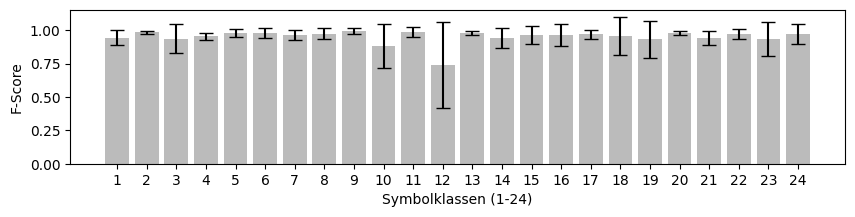

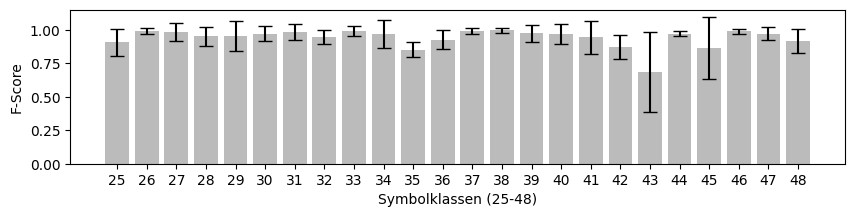

In [10]:
ac_means = []
ac_stds = []
for c in accuracies:
    mean = np.mean(accuracies[c])
    std = np.std(accuracies[c])
    ac_means.append(mean)
    ac_stds.append(std)

# Create lists for the plot
x_pos = np.arange(24) + 1

plt.figure(figsize=(10, 2))
plt.bar(x_pos, ac_means[:24], yerr=ac_stds[:24], align='center', capsize=5, color="#bbb", ecolor='black')#, alpha=0.5, ecolor='black', capsize=10
plt.xticks(np.arange(1, 24 + 1, 1.0))
plt.xlabel("Symbolklassen (1-24)")
plt.ylabel("F-Score")

x_pos = np.arange(24) + 1 + 24
plt.figure(figsize=(10, 2))
plt.bar(x_pos, ac_means[24:], yerr=ac_stds[24:], align='center', capsize=5, color="#bbb", ecolor='black')#, alpha=0.5, ecolor='black', capsize=10
plt.xticks(np.arange(1 + 24, 24 + 24 + 1, 1.0))
plt.xlabel("Symbolklassen (25-48)")
plt.ylabel("F-Score")
np.mean(ac_means), np.mean(ac_stds)